In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import random
import pandas as pd


device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Network Architecture**

In [ ]:
def crop_tensor(down_tensor, up_tensor):
  d_size = down_tensor.size()[2]
  u_size = up_tensor.size()[2]
  diff = (d_size - u_size)//2
  return down_tensor[:,:, diff:d_size-diff, diff:d_size-diff]

In [ ]:
class UNet(nn.Module):
  def __init__(self):
      super(UNet, self).__init__()


      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.double_conv_1 = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              nn.Conv2d(64, 64, kernel_size=3,stride=1, padding=1, bias=False), 
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True)
      )

      self.double_conv_2 = nn.Sequential(
              nn.Conv2d(64, 128, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True),
              nn.Conv2d(128, 128, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True)
      )

      self.double_conv_3 = nn.Sequential(
              nn.Conv2d(128, 256, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True)
      )

      self.double_conv_4 = nn.Sequential(
              nn.Conv2d(256, 512, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(inplace=True),
              nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(inplace=True)
      )

      self.double_conv_5 = nn.Sequential(
              nn.Conv2d(512, 1024, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(1024),
              nn.ReLU(inplace=True),
              nn.Conv2d(1024, 1024, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(1024),
              nn.ReLU(inplace=True)
      )

      #Decode

      self.upsample_1 = nn.ConvTranspose2d(in_channels=1024,
                                           out_channels = 512,
                                           kernel_size=2,
                                           stride = 2)
      
      self.double_upconv_1 = nn.Sequential(
             nn.Conv2d(1024, 512, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(inplace=True),
              nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(inplace=True)
      )

      self.upsample_2 = nn.ConvTranspose2d(in_channels=512,
                                           out_channels = 256,
                                           kernel_size=2,
                                           stride = 2)
      
      self.double_upconv_2 = nn.Sequential(
             nn.Conv2d(512, 256, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True)
      )

      self.upsample_3 = nn.ConvTranspose2d(in_channels=256,
                                           out_channels = 128,
                                           kernel_size=2,
                                           stride = 2)
      
      self.double_upconv_3 = nn.Sequential(
             nn.Conv2d(256, 128, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True),
              nn.Conv2d(128, 128, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True)
      )

      self.upsample_4 = nn.ConvTranspose2d(in_channels=128,
                                           out_channels = 64,
                                           kernel_size=2,
                                           stride = 2)
      
      self.double_upconv_4 = nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              nn.Conv2d(64, 64, kernel_size=3,stride=1, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True)
      )

      self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
      

  
  def forward(self,img):
    # input shape : (3, 256, 256)
    l_1 = self.double_conv_1(img) # (64, 256, 256)
    l_2 = self.maxpool(l_1) # (64, 128, 128)
    l_3 = self.double_conv_2(l_2) # (128, 128, 128)
    l_4 = self.maxpool(l_3) # (128, 64, 64)
    l_5 = self.double_conv_3(l_4) # (256, 64, 64)
    l_6 = self.maxpool(l_5) # (256, 32, 32)
    l_7 = self.double_conv_4(l_6) # (512, 32, 32)
    l_8 = self.maxpool(l_7) # (512, 16, 16)
    l_9 = self.double_conv_5(l_8) # (1024, 16, 16)

    #Decode
    x_1 = self.upsample_1(l_9) # (512, 32, 32)
    cropped_tensor_1 = crop_tensor(l_7, x_1) # (512, 32, 32)
    y_1 = self.double_upconv_1(torch.cat([x_1,cropped_tensor_1],1)) # (512, 32, 32)
    
    x_2 = self.upsample_2(y_1) # (256, 64, 64)
    cropped_tensor_2 = crop_tensor(l_5, x_2) # (256, 64, 64)
    y_2 = self.double_upconv_2(torch.cat([x_2,cropped_tensor_2],1)) # (256, 64, 64)
    
    x_3 = self.upsample_3(y_2) # (128, 128, 128)
    cropped_tensor_3 = crop_tensor(l_3, x_3) # (128, 128, 128)
    y_3 = self.double_upconv_3(torch.cat([x_3,cropped_tensor_3],1)) # (128, 128, 128)
    
    x_4 = self.upsample_4(y_3) # (64, 256, 256)
    cropped_tensor_4 = crop_tensor(l_1, x_4) # (64, 256, 256)
    y_4 = self.double_upconv_4(torch.cat([x_4,cropped_tensor_4],1)) # (64, 256, 256)
    
    out = self.out(y_4) # (1, 256, 256)
    
    return out




# **Dataset**

In [ ]:
class CarvanaDataset(Dataset):
  def __init__(self,image_dir, mask_dir, transform_train=None, transform_mask =None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform_train = transform_train
    self.transform_mask = transform_mask
    self.images = os.listdir(image_dir)

  def __len__(self):
   return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.images[idx])
    img_mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg","_mask.gif"))
    image = self.pil_loader(img_path)
    mask = self.pil_loader(img_mask_path, "mask")
    
    if self.transform_train is not None and self.transform_mask is not None:
      image = self.transform_train(image)
      mask = self.transform_mask(mask)
      
    return image, mask    


  def pil_loader(self,path, mask = None): 
        with open(path, 'rb') as f:
            img = Image.open(path)
            if mask == None:
              img.convert('RGB')
            else:
              img = img.convert("L")

            return img 


In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256,256),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

transform_mask = transforms.Compose([
    transforms.Resize((256,256),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    #transforms.Normalize((0), (1.0))   
])

In [ ]:
dataset = CarvanaDataset("/content/train/","/content/train_masks/",transform_train = transform_train, transform_mask=transform_mask)

In [ ]:
print(len(dataset))
train_size = int(0.99 * len(dataset))
eval_size = len(dataset) - train_size

train_data, validation_data = random_split(dataset, [train_size, eval_size])
print(len(train_data), len(validation_data))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
(256, 256, 3)
(256, 256)


<Figure size 432x288 with 0 Axes>

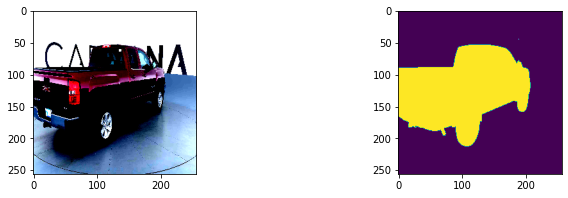

In [ ]:
plt.figure()
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3)) 
for imgs, mask in train_loader:
    print(imgs.shape, mask.shape)

    img = np.transpose(imgs[0].numpy(),(1,2,0))
    img = np.squeeze(img)
    print(img.shape)
    ax[0].imshow(img)
  
    im_mask = mask.numpy()
    im_mask = np.squeeze(im_mask)
    print(im_mask.shape)
    ax[1].imshow(im_mask)
    break

# **Training**

In [ ]:
model = UNet()

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 10, batch_size = 10, display_freq=5, device = 'cpu'):
    net = net.to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    criterion = torch.nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    loss_arr = [] 

    net.train()
    for i in range(n_batches):
        for j, (imgs, target) in enumerate(train_loader):

            opt.zero_grad()
            imgs = imgs.to(device_gpu)
            target = target.to(device_gpu)
            pred = net(imgs)
            loss = criterion(pred, target)
            
            loss.backward()
            opt.step()
            
        loss_arr.append(loss.item())    
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    return loss_arr

Iteration 9 Loss 0.009665237739682198


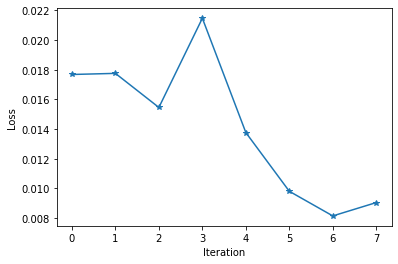

[0.031312283128499985,
 0.017681702971458435,
 0.017756924033164978,
 0.015459001995623112,
 0.021473437547683716,
 0.013766868971288204,
 0.009806893765926361,
 0.008146530017256737,
 0.009046894498169422,
 0.009665237739682198]

In [ ]:
train_setup(model, lr=0.01, n_batches=10, batch_size=32, display_freq=1, device=device_gpu)

# **Evaluation**

In [ ]:
def pixel_accuracy(prediction, ground_truth):
  correct = 0
  for idx in range(len(prediction)):
    for idy in range(len(prediction[idx])):
      if prediction[idx][idy] == ground_truth[idx][idy]:
        correct += 1

  return correct/(prediction.shape[0]*prediction.shape[1])

In [ ]:
def eval_fn(net, device = device_gpu):
  net.eval()
  eval_loader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True)
  for j, (imgs, target) in enumerate(eval_loader):
    orig = np.transpose(imgs[0].numpy(),(1,2,0))
    orig = np.squeeze(orig)

    imgs = imgs.to(device)
     
    out = net(imgs)
    threshold = torch.Tensor([0.5]).to(device)
    out = (torch.sigmoid(out) > threshold).float() * 1
    out = out.cpu().numpy()
    out = np.squeeze(out)

    target = target.numpy()
    target = np.squeeze(target)
    
    acc = pixel_accuracy(out, target)
    print(f"Pixel accuracy : {acc*100} %")
    list_images = [orig,target, out]
    list_title = ["Orignal Image ","Ground Truth", "Prediction"]
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    for k, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(list_images[k])
              
        plt.title(f"{list_title[k]}")
    plt.suptitle('Evaluation Results')
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.615478515625 %


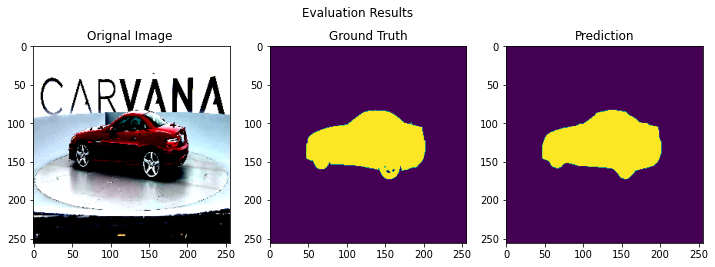

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.32403564453125 %


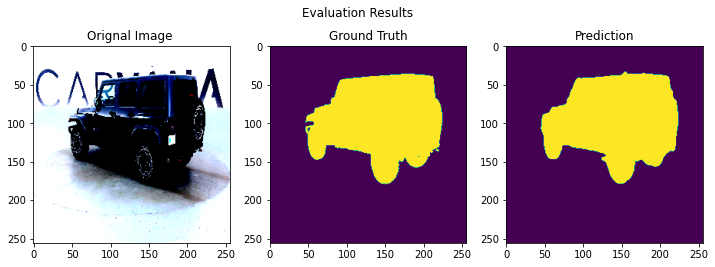

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 98.86627197265625 %


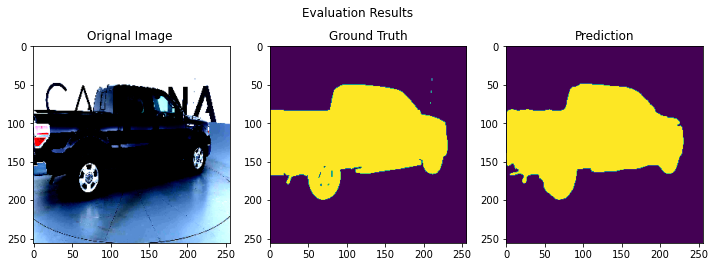

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.67498779296875 %


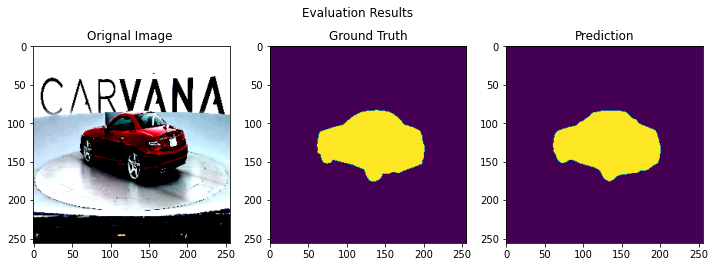

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.42626953125 %


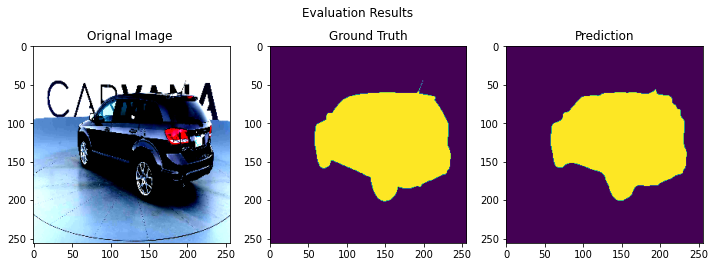

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.68414306640625 %


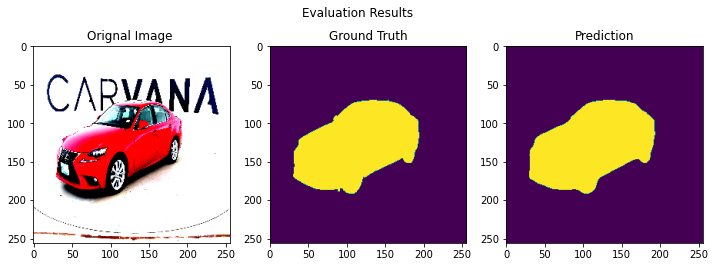

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.44610595703125 %


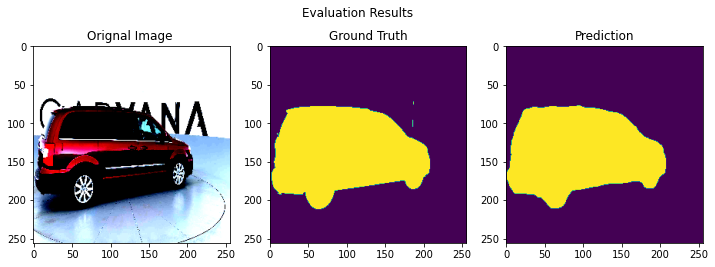

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.5513916015625 %


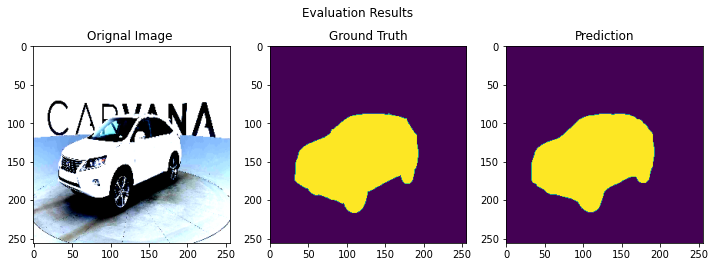

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 98.87542724609375 %


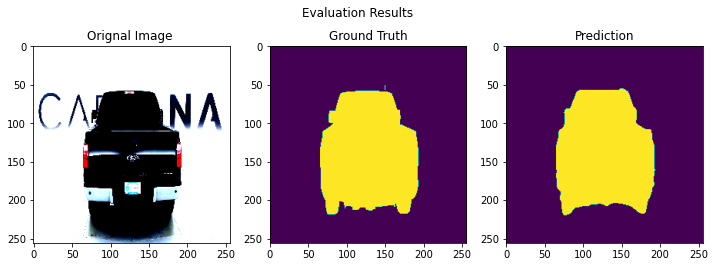

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pixel accuracy : 99.5086669921875 %


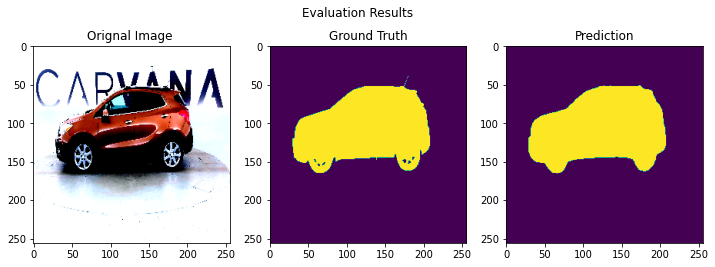

In [ ]:
eval_fn(model,device=device_gpu)